## Машинное обучение, ВМК МГУ

## Практическое задание 2

### Общая информация
Дата выдачи: 7 октября 2020

Максимальная оценка: 10 баллов + 1 бонусный балл

Мягкий дедлайн: 23:59MSK 20 октября

Жесткий дедлайн: 23:59MSK 27 октября.

### О задании

В этом задании вы:
- Познакомитесь с методом решения задачи регрессии на основе метода ближайших соседей.
- Реализуете алгоритм kNN для задачи регрессии.
- Изучите методы работы с категориальными и текстовыми переменными.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-02-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-02-ivanov.ipynb).

Далее отправьте этот файл на anytask в соответсвующий раздел.

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier


Все эксперименты в этой лабораторной работе предлагается проводить на данных соревнования New York City Airbnb Open Data: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data#AB_NYC_2019.csv

В данной задаче предлагается предсказать цену на съем квартиры в зависимости от её параметров.

In [2]:
data = pd.read_csv('AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
data.shape

(48895, 16)

In [4]:
# число значений у признаков
for col_name in data.columns:
    print(col_name, len(data[col_name].unique()))

id 48895
name 47906
host_id 37457
host_name 11453
neighbourhood_group 5
neighbourhood 221
latitude 19048
longitude 14718
room_type 3
price 674
minimum_nights 109
number_of_reviews 394
last_review 1765
reviews_per_month 938
calculated_host_listings_count 47
availability_365 366


In [5]:
data.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Как видите, в данных есть пропуски. Не забудьте обработать их

In [6]:
data['name'].fillna('')
data['last_review'].fillna(' ')
data['reviews_per_month'].fillna(0)

0        0.21
1        0.38
2        0.00
3        4.64
4        0.10
         ... 
48890    0.00
48891    0.00
48892    0.00
48893    0.00
48894    0.00
Name: reviews_per_month, Length: 48895, dtype: float64

Разобъем данные на обучение и контроль.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']), data[['price']],
                                                    test_size=0.3, random_state=241)

## Часть 1: Алгоритм kNN в задаче регрессии

<b> 1.1 (1.5 балла) </b>
Реализуйте класс `KNNRegressor`, который используя метод k ближайших соседей решает задачу регрессии. Для решение данной задачи, необходимо найти $N_k$ - k соседей, и после использовать значения их целевых переменных для предсказания:
\begin{align}
y = \frac{1}{k}\sum_{n \in N_k}w_n y_n,
\end{align}

где $w_n$ - вес каждого соседа. 

При этом `KNNRegressor` может работать в 2 режимах:
 - $uniform$ - ближайшие соседи учитываются с одинаковыми весами.
 - $distance$ - вес ближайших соседей зависит от расстояния
 
**Сигнатуру методов, классов, функции при желании можно менять.**

In [8]:
from typing import Union, Callable, Iterable, Optional
from sklearn.neighbors import NearestNeighbors


class KNNRegressor:
    def __init__(self, n_neighbors: int, metric: Union[str, Callable], mode: str = 'uniform'):
        """
        params:
            n_neighbors: number of neighbors
            metric: metric to use for distance computation
            mode: 'uniform' or 'distance'
            'uniform' - all points in each neighborhood are weighted equally
            'distance' - weight points by the inverse of their distance
        """
        self.__nn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric)
        self.__mode = mode
        self.__n_neighbors = n_neighbors

    def fit(self, X: np.array, y: np.array) -> None:
        """
            X: data
            y: labels
        """
        self.__nn.fit(X)
        self.X_train = X
        self.y_train = y



    def predict(self, X: np.array, n_neighbors: Optional[int] = None) -> np.array:
        """
            X: data
            n_neighbors: number of neighbors
        """

        dist, ind = self.__nn.kneighbors(X, n_neighbors=n_neighbors, return_distance=True)
        if self.__mode == 'distance':
            el_weights = 1 / (dist + 10 ** -5)
            coef = el_weights.sum(axis = 1)
            answers = self.y_train[ind] * el_weights
        else:
            answers = self.y_train[ind]
            coef = n_neighbors
        return answers.sum(axis = 1) / coef



## Часть 2: Категориальные признаки

<b>2.1 (1 балл)</b>
Реализуйте три функции расстояния на категориальных признаках _(в этом задании только на них!)_ , которые обсуждались на [втором семинаре](https://github.com/mmp-mmro-team/mmp_mmro_fall_2020/blob/master/seminars/sem02_knn.pdf). Не забудьте, что KNNRegressor должен уметь работать с этими функциями расстояния. Как вариант, можно реализовать метрики как [user-defined distance](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html).

In [23]:
def overlap(x, z):
    return np.sum(x != z)


class flattened_overlap:
    def fit(self, X_train):
        self.f = []
        self.l = X_train.shape[0]
        for column in X_train.T:
            d = dict(zip(*np.unique(column, return_counts=True)))
            self.f.append(d)

    def _f(self, j, x):
        if x in self.f[j].keys():
            return self.f[j][x]
        else:
            return 0

    def _p(self, j, x):
        return self._f(j, x) / self.l

    def _p_squared(self, j, x):
        return (self._f(j, x) * (self._f(j, x) - 1)) / (self.l * (self.l - 1))

    def __call__(self, x, z):
        result = 0
        for i in range(len(x)):
            if x[i] != z[i]:
                result += 1
            else:
                tresh = self._p(i, x[i])
                for q in self.f[i].keys():
                    if self._p(i, q) <= tresh:
                        result += self._p_squared(i, q)
        return result

class log_overlap:
    def fit(self, X_train):
        self.f = []
        self.l = X_train.shape[0]
        for column in X_train.T:
            d = dict(zip(*np.unique(column, return_counts=True)))
            self.f.append(d)

    def _f(self, j, x):
        if x in self.f[j].keys():
            return self.f[j][x]
        else:
            return 0

    def __call__(self, x, z):
        result = 0
        for i in range(len(x)):
            if x[i] != z[i]:
                result += np.log(self._f(i, x[i]) + 1) * np.log(self._f(i, z[i]) + 1)
        return result

<b>2.2 (1 балл)</b> Найдите все категориальные признаки в данных. Подсчитайте для каждой из метрик качество на тестовой выборке `X_test` при числе соседей $k = 10$. Качество измеряйте с помощью RMSE.

Какая функция расстояния оказалась лучшей? Почему?

In [8]:
for col_name in data.columns:
    print(col_name, data[col_name].nunique())
X_train_cat = X_train[['neighbourhood_group', 'neighbourhood', 'room_type']]
X_test_cat = X_test[['neighbourhood_group', 'neighbourhood', 'room_type']]

id 48895
name 47905
host_id 37457
host_name 11452
neighbourhood_group 5
neighbourhood 221
latitude 19048
longitude 14718
room_type 3
price 674
minimum_nights 109
number_of_reviews 394
last_review 1764
reviews_per_month 937
calculated_host_listings_count 47
availability_365 366


In [9]:
pd.options.mode.chained_assignment = None
for i in range(3):
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(np.concatenate((X_train_cat.iloc[:, i].values, X_test_cat.iloc[:, i].values)))
    X_train_cat.iloc[:, i] = label_encoder.transform(X_train_cat.iloc[:, i])
    X_test_cat.iloc[:, i] = label_encoder.transform(X_test_cat.iloc[:, i])

Overlap

In [12]:
%%time
clf = KNNRegressor(10, overlap, 'distances')
clf.fit(X_train_cat.values, y_train.values)
res_overlap = clf.predict(X_test_cat.values)

Wall time: 16min 39s


RMSE for overlap

In [13]:
np.sqrt(((res_overlap - y_test.values.flatten()) ** 2).mean())

217.16567261249645

Flatten overlap

In [26]:
%%time
flatten_overlap = flattened_overlap()
flatten_overlap.fit(X_train_cat.values)
clf = KNNRegressor(10, flatten_overlap, 'distances')
clf.fit(X_train_cat.values, y_train.values.flatten())
res_log = clf.predict(X_test_cat.values, 10)


Wall time: 3h 5min 40s


RMSE for flatten overlap

In [27]:
np.sqrt(((res_log - y_test.values.flatten()) ** 2).mean())

217.14257662200606

Log overlap

In [24]:
%%time
log_overlap_ = log_overlap()
log_overlap_.fit(X_train_cat.values)
clf = KNNRegressor(10, log_overlap_, 'distances')
clf.fit(X_train_cat.values, y_train.values.flatten())
res_logo = clf.predict(X_test_cat.values, 10)

Wall time: 44min 39s


RMSE for Log overlap

In [25]:
np.sqrt(((res_logo - y_test.values.flatten()) ** 2).mean())

217.1993405123174

Вывод по данным результатам:

Наилучшие результаты показала модель, использующая метрику сглажевания индикатора совпадения(flatten overlap).
Из этого можно сделать вывод, что в выборке много равных объектов, но с разными частотами признаков.

<b>2.3 (1 балл) бонус</b> Подберите лучшее (на тестовой выборке) число соседей $k$ для каждой из функций расстояния. Какого удалось достичь уровня качества?

In [ ]:
# Ваш код здесь

<b>2.4 (2.5 балла)</b> Отойдем ненадолго от задачи регрессии и перейдём к задаче классификации: будем определять, являеться ли квартира дорогой $(target = 1)$ или дешевой $(target = 0)$. Будем считать дорогими квариры, цена которых выше среднего.

In [34]:
data['target'] = (data.price > data.price.mean()).astype(int)

X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']), data[['price']],
                                                    test_size=0.3, random_state=241)

Реализуйте счетчики, которые заменят категориальные признаки на вещественные.

А именно, для каждого категориального признака $f_j(x)$ необходимо сделать следующее:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
\begin{align}
counts_j(c) = \sum_{i=1}^l [f_j(x_i) = c]
\end{align}
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
\begin{align}
successes_j(c) = \sum_{i=1}^l[f_j(x_i) = c][y_i = +1].
\end{align}
3. Сглаженное отношение двух предыдущих величин:
\begin{align}
p_j(c) = \frac{successes_j(c) + a}{counts_j(c) + b},
\end{align}

где $a$ и $b$ - априорные счетчики (например, a = 1, b = 2).

In [25]:
def counts(X_train, X_test):
    d = dict(zip(*np.unique(X_train, return_counts=True)))
    return np.array([d[t] if t in d.keys() else 0 for t in X_test])

def success(X_train, y, X_test):
    u = X_train[y == 1]
    d = dict(zip(*np.unique(u, return_counts=True)))
    return np.array([d[t] if t in d.keys() else 0 for t in X_test])

def p(x, X_train, y_train, a, b):
    return (success(x, X_train, y_train) + a) / (counts(x, y_train) + b)

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанный по всей обучающей выборке. Реализуйте и такой вариант. Достаточно взять $n = 3$.

In [14]:
def kfold(n, n_folds=3):
    all_idx = range(n)
    folds = np.array_split(all_idx, n_folds)
    res = []
    for k in range(n_folds):
        if k == 0:
            edu = np.hstack(folds[k + 1:])
        elif k == n_folds - 1:
            edu = np.hstack(folds[:k])
        else:
            edu = np.hstack((np.hstack(folds[:k]), np.hstack(folds[k + 1:])))
        val = folds[k]
        res.append((edu, val))
    return res

def fold_counters(x, labels):
    """
    params:
        x: value on categorical feature for N objects
    returns: vector of length N
    """
    result1 = np.zeros(len(x))
    result2 = np.zeros(len(x))
    result3 = np.zeros(len(x))
    folds = kfold(len(x))
    for idx_train, idx_test in folds:
        result1[idx_test] = p(x[idx_train], labels[idx_train], x[idx_test], 1, 2)
        result2[idx_test] = counts(x[idx_train], x[idx_test])
        result3[idx_test] = success(x[idx_train], labels[idx_train], x[idx_test])
    return result1, result2, result3

Посчитайте на тесте AUC-ROC метода $k$ ближайших соседей с евклидовой метрикой для выборки, где категориальные признаки заменены на счетчики. Сравните по AUC-ROC два варианта формирования выборки — с фолдингом и без. Не забудьте подобрать наилучшее число соседей $k$.

Заменяем признаки на счетчики с фолдингом


In [40]:
X_train_cat = X_train[['neighbourhood_group', 'neighbourhood', 'room_type', 'target']]
X_test_cat = X_test[['neighbourhood_group', 'neighbourhood', 'room_type', 'target']]

target_train = X_train_cat['target'].values
target_test = X_test_cat['target'].values

for name in ['neighbourhood_group', 'neighbourhood', 'room_type']:
    p_ = p(X_train_cat[name].values, target_train, X_test_cat[name].values, 1, 2)
    counts_ = counts(X_train_cat[name].values, X_test_cat[name].values)
    success_ = success(X_train_cat[name].values, target_train, X_test_cat[name].values)

    X_test_cat[name + '_p'] = p_
    X_test_cat[name + '_c'] = counts_
    X_test_cat[name + '_s'] = success_
    t_p, t_counts, t_success = fold_counters(X_train_cat[name].values, target_train)
    X_train_cat[name + '_f'] = t_p
    X_train_cat[name + '_c'] = t_counts
    X_train_cat[name + '_s'] = t_success
X_train_cat.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type', 'target'], inplace=True)
X_test_cat.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type', 'target'], inplace=True)

AUC-ROC с фолдингом

In [41]:
pd.options.mode.chained_assignment = None
k_range = np.arange(1, 100, 5)

norm = Normalizer()
norm.fit(X_train_cat)
X_train_cat = norm.transform(X_train_cat)
X_test_cat = norm.transform(X_test_cat)
best_k = -1
max_score = -1
for k in k_range:
    clf = KNeighborsClassifier(k, metric='euclidean', weights='distance')
    clf.fit(X_train_cat, target_train)
    pred = clf.predict_proba(X_test_cat)[:, 1]
    score = roc_auc_score(target_test, pred)
    if score > max_score:
        best_k = k
        max_score = score
print(f'best results: k = {best_k}, AUC-ROC = {max_score}')


best results: k = 91, AUC-ROC = 0.8668711579869955


Заменяем признаки на счетчики без фолдинга

In [42]:
X_train_cat = X_train[['neighbourhood_group', 'neighbourhood', 'room_type', 'target']]
X_test_cat = X_test[['neighbourhood_group', 'neighbourhood', 'room_type', 'target']]

target_train = X_train_cat['target'].values
target_test = X_test_cat['target'].values

for name in ['neighbourhood_group', 'neighbourhood', 'room_type']:
    p_ = p(X_train_cat[name].values, target_train, X_test_cat[name].values, 1, 2)
    counts_ = counts(X_train_cat[name].values, X_test_cat[name].values)
    success_ = success(X_train_cat[name].values, target_train, X_test_cat[name].values)

    X_test_cat[name + '_p'] = p_
    X_test_cat[name + '_c'] = counts_
    X_test_cat[name + '_s'] = success_

    t_p = p(X_train_cat[name].values, target_train, X_train_cat[name].values, 1, 2)
    t_counts = counts(X_train_cat[name].values, X_train_cat[name].values)
    t_success = success(X_train_cat[name].values, target_train, X_train_cat[name].values)

    X_train_cat[name + '_f'] = t_p
    X_train_cat[name + '_c'] = t_counts
    X_train_cat[name + '_s'] = t_success
X_train_cat.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type', 'target'], inplace=True)
X_test_cat.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type', 'target'], inplace=True)

AUC-ROC без фолдингов

In [43]:
k_range = np.arange(1, 100, 5)

norm = Normalizer()
norm.fit(X_train_cat)
X_train_cat = norm.transform(X_train_cat)
X_test_cat = norm.transform(X_test_cat)
best_k = -1
max_score = -1
for k in k_range:
    clf = KNeighborsClassifier(k, metric='euclidean', weights='distance')
    clf.fit(X_train_cat, target_train)
    pred = clf.predict_proba(X_test_cat)[:, 1]
    score = roc_auc_score(target_test, pred)
    if score > max_score:
        best_k = k
        max_score = score
print(f'best results: k = {best_k}, AUC-ROC = {max_score}')

best results: k = 96, AUC-ROC = 0.8633880894685682


В итоге я получил незначительную разность(~ 0.003)  AUC-ROC для фолдов и без. Получается замена данных на счетчики
в данном случае не приводит к переобучению.

<b>2.5 (1 балл)</b> Вернемся к задаче регрессии. Утверждается, что для задачи регрессии можно также сделать преобразование категориальных признаков в действительные числа. Для этого достаточно для каждого значения признака $f_j$ вычислить:
\begin{align}
p_j(c) = g(T_i | f_j(x_i) = c),
\end{align}

где $T_i$ - значения целевой переменной объекта $x_i$. Функция $g$ - среднее (mean) или среднеквадратичное отклонение (std).

Закодируйте категориальные признаки обоими способами и найдите значение RMSE. Используйте евклидову метрику для поиска ближайших соседей. Для какой функции $g$ значение RMSE лучше? Почему?

Mean кодировка

In [50]:
X_train_cat = X_train[['neighbourhood_group', 'neighbourhood', 'room_type']]
X_test_cat = X_test[['neighbourhood_group', 'neighbourhood', 'room_type']]
X_train_cat['cost'] = y_train

In [51]:
for name in ['neighbourhood_group', 'neighbourhood', 'room_type']:
    encode = X_train_cat[[name, 'cost']].groupby(name).agg('mean')['cost'].to_dict()
    X_test_cat[name + '_en'] = np.array([encode[t] if t in encode.keys() else 0 for t in X_test_cat[name].values])
    X_train_cat[name + '_en'] = np.array([encode[t] if t in encode.keys() else 0 for t in X_train_cat[name].values])


X_train_cat.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type', 'cost'], inplace=True)
X_test_cat.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type'], inplace=True)

RMSE for Mean

In [58]:
k_range = np.arange(1, 100, 5)

norm = Normalizer()
norm.fit(X_train_cat)
X_train_cat = norm.transform(X_train_cat)
X_test_cat = norm.transform(X_test_cat)
best_k = -1
max_score = 10000
for k in k_range:
    knn = KNNRegressor(k, metric='euclidean', mode='distance')
    knn.fit(X_train_cat, y_train.values.flatten())
    pred = knn.predict(X_test_cat)
    score = np.sqrt(((pred - y_test.values.flatten()) ** 2).mean())
    if score < max_score:
        best_k = k
        max_score = score
print(f'best results: k = {best_k}, best RMSE = {max_score}')

best results: k = 81, best RMSE = 207.55551982688328


Std кодировка

In [62]:
X_train_cat = X_train[['neighbourhood_group', 'neighbourhood', 'room_type']]
X_test_cat = X_test[['neighbourhood_group', 'neighbourhood', 'room_type']]
X_train_cat['cost'] = y_train

In [63]:
for name in ['neighbourhood_group', 'neighbourhood', 'room_type']:
    encode = X_train_cat[[name, 'cost']].groupby(name).agg('std')['cost'].to_dict()
    X_test_cat[name + '_en'] = np.array([encode[t] if t in encode.keys() else 0 for t in X_test_cat[name].values])
    X_train_cat[name + '_en'] = np.array([encode[t] if t in encode.keys() else 0 for t in X_train_cat[name].values])

X_train_cat.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type', 'cost'], inplace=True)
X_test_cat.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type'], inplace=True)

RMSE for Std

In [65]:
k_range = np.arange(1, 100, 5)

X_train_cat.fillna(0, inplace=True)
X_test_cat.fillna(0, inplace=True)

norm = Normalizer()
norm.fit(X_train_cat)
X_train_cat = norm.transform(X_train_cat)
X_test_cat = norm.transform(X_test_cat)
best_k = -1
max_score = 10000
for k in k_range:
    knn = KNNRegressor(k, metric='euclidean', mode='distance')
    knn.fit(X_train_cat, y_train.values.flatten())
    pred = knn.predict(X_test_cat)
    score = np.sqrt(((pred - y_test.values.flatten()) ** 2).mean())
    if score < max_score:
        best_k = k
        max_score = score
print(f'best results: k = {best_k}, best RMSE = {max_score}')

best results: k = 96, best RMSE = 208.2473800984568


На основе этого задания результаты mean оказалась немного лучше, чем Std(разница ~ 0.69). Так как разница
достаточно мала, недостаточно данных для выявления закономерностей.

## Часть 3: Текстовые признаки

<b>3.1 (2 балла)</b> Перейдем от категориальным признаков к текстовым. Рассмотрим 2 способа преобразования текста в действительные числа:
- Мешок слов (Bag of Words)
- TF-IDF

[Здесь](https://scikit-learn.org/stable/modules/feature_extraction.html) вы можете прочитать про их применение в Питоне.

Сравните оба способа на задаче регресси. Какую лучше метрику использовать: евклидову или косинусную меру? Постройте графики зависимости качества решения задачи от способа преобразования, метрики и количества соседей. Мера качества - RMSE.

Объясните полученные результаты.

Перед преобразованием не забудьте уменьшить размер словаря. Например, это можно сделать за счет приведения всех слов к одному регистру и удаления [стопслов](https://en.wikipedia.org/wiki/Stop_words) (артиклей, предлогов, союзов). Можно использовать использовать, например, библиотеку nltk.

Bag of words

Подготовка мешка слов

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

X_train_cat = X_train['name']
X_test_cat = X_test['name']
np.where(X_test_cat == np.nan)
#f = CountVectorizer(stop_words='english')
#f3_train = f.fit_transform(X_train_cat.values).toarray()
# f3_test = f.transform(X_test_cat.values).toarray()
# bw_train = np.concatenate(f3_train, axis=1)
# bw_test = np.concatenate(f3_test, axis=1)

(array([], dtype=int64),)

RMSE by euclidian for Bag of words

In [92]:
k_range = np.arange(1, 100, 5)

norm = Normalizer()
norm.fit(bw_train)
X_train_cat = norm.transform(bw_train)
X_test_cat = norm.transform(bw_test)
best_k = -1
max_score = 10000
scores = np.arange(1, 100, 5)
for i, k in enumerate(k_range):
    knn = KNNRegressor(k, mode='uniform', metric='euclidean')
    knn.fit(X_train_cat, y_train.values.flatten())
    pred = knn.predict(X_test_cat, k)
    score = np.sqrt(((pred - y_test.values.flatten()) ** 2).mean())
    scores[i] = score
    if score < max_score:
        best_k = k
        max_score = score
print(f'best results: k = {best_k}, best RMSE = {max_score}')

best results: k = 91, best RMSE = 206.6366788036051


График Bag of words(euclidian)

Text(0.5, 1.0, 'График зависимости RMSE для Bag of words with euclidean metric')

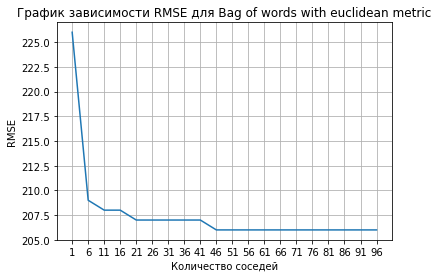

In [94]:
import matplotlib.pyplot as plt
plt.plot(k_range, scores)
plt.grid()
plt.xticks(k_range)
plt.xlabel('Количество соседей')
plt.ylabel('RMSE')
plt.title('График зависимости RMSE для Bag of words with euclidean metric')

RMSE by cosine for Bag of words

In [95]:
# k_range = np.arange(1, 100, 5)
# norm = Normalizer()
# norm.fit(bw_train)
# X_train_cat = norm.transform(bw_train)
# X_test_cat = norm.transform(bw_test)
best_k = -1
max_score = 10000
scores_cb = np.arange(1, 100, 5)
for i, k in enumerate(k_range):
    knn = KNNRegressor(k, mode='uniform', metric='cosine')
    knn.fit(X_train_cat, y_train.values.flatten())
    pred = knn.predict(X_test_cat, k)
    score = np.sqrt(((pred - y_test.values.flatten()) ** 2).mean())
    scores_cb[i] = score
    if score < max_score:
        best_k = k
        max_score = score
print(f'best results: k = {best_k}, best RMSE = {max_score}')

best results: k = 96, best RMSE = 206.71734083069305


График Bag of words(cosine)

Text(0.5, 1.0, 'График зависимости RMSE для Bag of words with cosine metric')

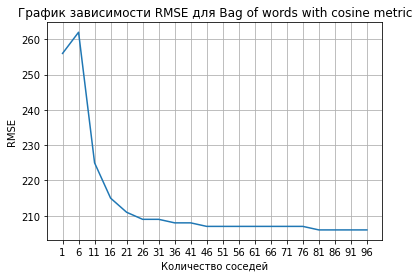

In [96]:
plt.plot(k_range, scores_cb)
plt.grid()
plt.xticks(k_range)
plt.xlabel('Количество соседей')
plt.ylabel('RMSE')
plt.title('График зависимости RMSE для Bag of words with cosine metric')


TF-IDF

Подготовка мешка слов

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train_cat = X_train[['neighbourhood_group', 'neighbourhood', 'room_type']]
X_test_cat = X_test[['neighbourhood_group', 'neighbourhood', 'room_type']]

f = TfidfVectorizer(stop_words='english')
f1_train = f.fit_transform(np.array(X_train_cat['neighbourhood_group'])).toarray()
f1_test = f.transform(np.array(X_test_cat['neighbourhood_group'])).toarray()
f2_train = f.fit_transform(np.array(X_train_cat['neighbourhood'])).toarray()
f2_test = f.transform(np.array(X_test_cat['neighbourhood'])).toarray()
f3_train = f.fit_transform(np.array(X_train_cat['room_type'])).toarray()
f3_test = f.transform(np.array(X_test_cat['room_type'])).toarray()
bw_train = np.concatenate((f1_train, f2_train, f3_train), axis=1)
bw_test = np.concatenate((f1_test, f2_test, f3_test), axis=1)

RMSE by euclidian for TF-IDF

In [98]:
k_range = np.arange(1, 100, 5)

norm = Normalizer()
norm.fit(bw_train)
X_train_cat = norm.transform(bw_train)
X_test_cat = norm.transform(bw_test)
best_k = -1
max_score = 10000
scores = np.arange(1, 100, 5)
for i, k in enumerate(k_range):
    knn = KNNRegressor(k, mode='uniform', metric='euclidean')
    knn.fit(X_train_cat, y_train.values.flatten())
    pred = knn.predict(X_test_cat, k)
    score = np.sqrt(((pred - y_test.values.flatten()) ** 2).mean())
    scores[i] = score
    if score < max_score:
        best_k = k
        max_score = score
print(f'best results: k = {best_k}, best RMSE = {max_score}')

best results: k = 96, best RMSE = 206.9809376985742


График TF-IDF(euclidian)

Text(0.5, 1.0, 'График зависимости RMSE для TF-IDF with euclidean metric')

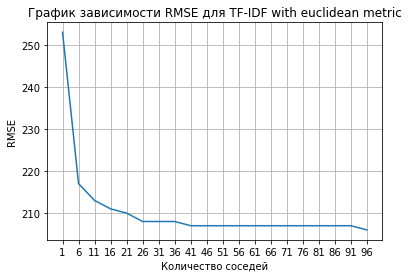

In [101]:
import matplotlib.pyplot as plt
plt.plot(k_range, scores)
plt.grid()
plt.xticks(k_range)
plt.xlabel('Количество соседей')
plt.ylabel('RMSE')
plt.title('График зависимости RMSE для TF-IDF with euclidean metric')

RMSE by cosine TF-IDF

In [99]:
# k_range = np.arange(1, 100, 5)
# norm = Normalizer()
# norm.fit(bw_train)
# X_train_cat = norm.transform(bw_train)
# X_test_cat = norm.transform(bw_test)
best_k = -1
max_score = 10000
scores_cb = np.arange(1, 100, 5)
for i, k in enumerate(k_range):
    knn = KNNRegressor(k, mode='uniform', metric='cosine')
    knn.fit(X_train_cat, y_train.values.flatten())
    pred = knn.predict(X_test_cat, k)
    score = np.sqrt(((pred - y_test.values.flatten()) ** 2).mean())
    scores_cb[i] = score
    if score < max_score:
        best_k = k
        max_score = score
print(f'best results: k = {best_k}, best RMSE = {max_score}')

best results: k = 91, best RMSE = 207.38279233990082


График Bag of words(cosine)

Text(0.5, 1.0, 'График зависимости RMSE для TF-IDF with cosine metric')

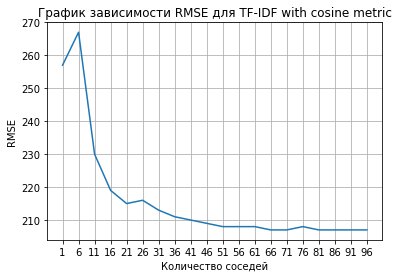

In [100]:
plt.plot(k_range, scores_cb)
plt.grid()
plt.xticks(k_range)
plt.xlabel('Количество соседей')
plt.ylabel('RMSE')
plt.title('График зависимости RMSE для TF-IDF with cosine metric')

При учитывании большого числа соседей, оба метода при использовании 2 метрик показывают примерно
одинаковые результаты. Однако при учитывании < 20 соседей Мешок со словами для евкидовой метрики
показывает лучший результат.

<b>3.2 (1 балл)</b> Используя все доступные признаки, решите задачу регрессии. Для категориальных и текстовых признаков выберите лучшие преобразования (из сделанных раннее заданий). Повлияло ли добавление количественного признака на метрику качества?

In [40]:
train = X_train.iloc[:, 4:]
train.drop(columns=['number_of_reviews', 'availability_365', 'last_review', 'neighbourhood_group', 'neighbourhood', 'room_type'], inplace=True)
train = train.fillna(0)
train.head()

,latitude,longitude,minimum_nights,reviews_per_month,calculated_host_listings_count,target
39319,40.63628,-73.96970,2,3.67,3,0
22796,40.73401,-73.98140,2,0.58,1,1
26190,40.74722,-73.91860,2,0.91,4,0
8161,40.77357,-73.95193,1,0.00,1,1
32473,40.72714,-73.98215,2,2.74,1,1


Применим мешок со словами на евкидовой метрики, как самый оптимальный вариант

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

X_train_cat = X_train[['neighbourhood_group', 'neighbourhood', 'room_type']]
X_test_cat = X_test[['neighbourhood_group', 'neighbourhood', 'room_type']]

f = CountVectorizer(stop_words='english')
f1_train = f.fit_transform(np.array(X_train_cat['neighbourhood_group'])).toarray()
f1_test = f.transform(np.array(X_test_cat['neighbourhood_group'])).toarray()
f2_train = f.fit_transform(np.array(X_train_cat['neighbourhood'])).toarray()
f2_test = f.transform(np.array(X_test_cat['neighbourhood'])).toarray()
f3_train = f.fit_transform(np.array(X_train_cat['room_type'])).toarray()
f3_test = f.transform(np.array(X_test_cat['room_type'])).toarray()
bw_train = np.concatenate((f1_train, f2_train, f3_train), axis=1)
bw_test = np.concatenate((f1_test, f2_test, f3_test), axis=1)

resulting_train = np.concatenate((train.values, bw_train), axis=1)
test = X_test.iloc[:, 4:]
test.drop(columns=['number_of_reviews', 'availability_365', 'last_review', 'neighbourhood_group', 'neighbourhood', 'room_type'], inplace=True)
test = test.fillna(0)
resulting_test = np.concatenate((test.values, bw_test), axis=1)

Решим задачу регрессии

In [45]:
nrm = Normalizer()
nrm.fit(resulting_train)
final_train = nrm.transform(resulting_train)
final_test = nrm.transform(resulting_test)

scores = np.arange(1, 100, 5)

for i, k in enumerate(scores):
    mdl = KNNRegressor(k, mode='uniform', metric='euclidean')
    mdl.fit(final_train, y_train.values.flatten())
    pred = mdl.predict(final_test, k)
    score = np.sqrt(((pred - y_test.values.flatten()) ** 2).mean())
    scores[i] = score
np.min(scores)

196

Text(0.5, 1.0, 'График зависимости RMSE для задачи регрессии')

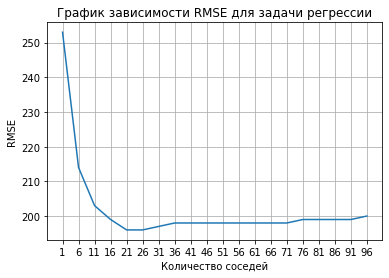

In [47]:
import matplotlib.pyplot as plt
k_range = np.arange(1, 100, 5)
plt.plot(k_range, scores)
plt.grid()
plt.xticks(k_range)
plt.xlabel('Количество соседей')
plt.ylabel('RMSE')
plt.title('График зависимости RMSE для задачи регрессии')

Добавив количественные признаки я получил минимальный RMSE = 196, что действительно лучше, чем на предыдущих опытах.

## Часть 4: Выводы


В этом задании я научился на практике применять метод решения задачи регрессии
на основе метода ближайших соседей. Реализовал алгоритм kNN для задачи регрессии.
Изучил методы работы с категориальными и текстовыми переменными.
При решении задачи с использованием только категориальных признаков лучшая достигнутая точность получилась RMSE=207.55.
При использовании только текстового признака минимальная RMSE=206.63.
Текст при этом закодирован методом Мешка слов и использована евклидова метрика.
При решении задачи со всеми признаками, включая числовые, ошибка уменьшается до 196,
то есть использование всех признаков повышет качество работы.
Выполненные эксперименты показывают, что для решения задачи регрессии алгоритмом ближайших соседей важно
оптимально настроить гипермапаметры: функцию расстояния между объектами, число ближайших соседей,
выбрать преобразованиия для признаков. Сложность заключается в том, что для разных типов признаков,
как-то: категориальные, текстовые, числовые, лучшая метрика и число соседей могут не совпадать,
что показывает последний эксперимент с подбором количества соседей. Оптимальным стал результат в 20 соседей, хотя
в предыдущих эксперементах был > 80.